# Overview notebook on "CMIP6 data analysis with PCMCI"

Import of the relevant package, the most important ones being :
    - iris, used for the handling of the climate data file
    - tigramite which includes the PCMCI implementation

In [129]:
#!jupyter nbconvert  "Overview of the project - Notebook - CMIP6.ipynb" --to pdf

In [1]:
import glob
from matplotlib import pyplot as plt
%matplotlib inline
## use `%matplotlib notebook` for interactive figures
import pickle
# plt.style.use('ggplot')
#import iris
import numpy as np
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
import pandas as pd
import scienceplots
plt.style.use(['science','nature'])
# plt.style.use(['science','nature'])

Decide what to run to avoid running heavy cells without noticing :), by default the iPyNB only run plot

In [2]:
run_preprocessing = False
run_PCMCI = False
run_PCA = False
save_res= True
make_dic= False
use_CMIP6_data=True
plot_figure = True
time_bin=1

Define paths to CMIP5 or CMIP6 data folders depending on use_CMIP6_data boolean value for the rest of the notebook

In [3]:
if use_CMIP6_data:
    #define all paths to CMIP6 data folders
    

    #all psl paths
    psl_1979_2014_path="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/detrend_data/"
    pca_res_path="/work/bd1083/b309165/CMIP6_CME/output_pca/CMIP6_era5_1979-2014_weights_timebin1/"
    #pcmci_res_path="/work/bd1083/b309165/CMIP6_CME/output_pcmci/CMIP6_ncar_1979-2014_weights_and_pr_mean_timebin1x2_alllinks/"
    pcmci_res_path="/work/bd1083/b309165/CMIP6_CME/output_pcmci/CMIP6_era5_1979-2014_weights_timebin1x2_selectedcomps/"
    #pr paths
    pr_histo_path = "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1979-2014_pr_study_timebinned_masked/"
    pr_scenario_path = "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/%s_data/"
    #piControl_path= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/piControl_data/"
    pr_1979_2014_path= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1979-2014_data/"
    #csv/bin output files
    global_res_path = "/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_link_and_parents_1979-2014_era5_weights_psl_timebin1x2.bin"
    delta_precip_file="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/delta_precip_histo_1860-1910_vs_%s_2050-2100_final_version.csv"
    sscore_file="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/seasonnal_S_score_model_versus_%s.csv"
   

In [4]:
make_dic= True

In [5]:
from tigramite.models import LinearMediation, Prediction
from tigramite.toymodels import structural_causal_processes as toys

def get_val_matrix_and_AK(file_path,file_name,graph):
        print("Calculating val_matrix ...")
        datadict = pickle.load(open(file_path, 'rb'))
        #get pr data
        season = str(datadict['results']["month_mask"])
        pr_files_path = "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1979-2014_pr_study_timebinned_masked/"
        region_list= ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]
        ts_unmasked_pr= []
        time_mask_pr = []
        model_split= file_name.split("_")
        for region in region_list:
            if model_split[2]=="ncar":
                model_split[2]= "NCEP"
                model_split[5]="pr"
            pr_file_name= pr_files_path+region+"/*"+model_split[2]+"*"+model_split[5]+"*"+season[0:2]+"*.bin"
            pr_file_name= glob.glob(pr_file_name)
            #print(pr_file_name)
            pr_file_name= pr_file_name[0]
            data_t= pickle.load(open(pr_file_name, 'rb'))
            d_t= data_t["results"]
            time_mask_pr.append(d_t["time_mask"])
            ts_unmasked_pr.append(d_t["ts_unmasked"])

        d = datadict['results']
        time_mask = d['time_mask']
        fulldata = d['ts_unmasked']
        N = fulldata.shape[1]
        fulldata_mask = np.repeat(time_mask.reshape(len(d['time']), 1),
                                     N,
                                     axis=1)
        pr_mask = np.array(time_mask_pr).T
        if "[12, 1, 2]" in file_name:
            selected_comps_file="/work/bd1083/b309165/CMIP6_CME/script/selected_comps_files_1979-2014_timebin1/selected_comps_NCEP_djf.csv"
        elif "[3, 4, 5]" in file_name:
            selected_comps_file="/work/bd1083/b309165/CMIP6_CME/script/selected_comps_files_1979-2014_timebin1/selected_comps_NCEP_mam.csv"
        elif "[6, 7, 8]" in file_name:
            selected_comps_file="/work/bd1083/b309165/CMIP6_CME/script/selected_comps_files_1979-2014_timebin1/selected_comps_NCEP_jja.csv"
        elif "[9, 10, 11]" in file_name:
            selected_comps_file="/work/bd1083/b309165/CMIP6_CME/script/selected_comps_files_1979-2014_timebin1/selected_comps_NCEP_son.csv"

        comps_csv = pd.read_csv(selected_comps_file)
        selected_comps_indices=[]
        selected_components = []
        n_VAR = 50#########PARAMETER
        for i in range(1, n_VAR+1):
            selected_components.append('c' + str(i))
        #print(selected_components)
        for i in range(len(selected_components)):
            selected_comps_indices.append(int(comps_csv["comps"][i]))
        #print(selected_comps_indices)
        fulldata = fulldata[:, selected_comps_indices]
        fulldata_mask = fulldata_mask[:, selected_comps_indices]
        pr = np.array(ts_unmasked_pr).T
        fulldata = np.hstack((fulldata,pr))
        fulldata_mask = np.hstack((fulldata_mask,pr_mask))
        #print("Fulldata shape = %s" % str(fulldata.shape))
        #print("Fulldata masked shape = %s" % str(fulldata_mask.shape))
        #print("Aggregating data to time_bin_length=%s" %time_bin)
        fulldata = pp.time_bin_with_mask(fulldata, time_bin_length=time_bin)[0]
        fulldata_mask = pp.time_bin_with_mask(fulldata_mask, time_bin_length=time_bin)[0] > 0.
        #print("Fulldata after binning shape = %s" % str(fulldata.shape))
        #print("Fulldata after binning masked shape = %s" % str(fulldata_mask.shape))
        dataframe = pp.DataFrame(fulldata, mask=fulldata_mask)
        #print(graph)
        parents = toys.dag_to_links(graph)
        med = LinearMediation(dataframe=dataframe)
        med.fit_model(all_parents=parents, tau_max=10)
        val_matrix = med.get_val_matrix(symmetrize=True)
        AK = np.sum(val_matrix[:,:,:],axis=2)
        return val_matrix,AK
        

In [6]:
save_global_res= True #only used if make_dic=True
selected_comps_indices=[i for i in range(0,50)]
var_names=["X_"+str(i) for i in range(0,50)]
alpha_list = [0.0001] #[0.01,0.001,0.0001,0.00001]
if make_dic:
    link_mat_alpha_dic = {}
    link_mat_dic= {}
    val_mat_dic={}
    val_mat_alpha_dic={}
    p_mat_dic={}
    p_mat_alpha_dic={}
    q_mat_dic={}
    q_mat_alpha_dic={}
    ak_dic={}
    ak_alpha_dic={}
    for alpha_level in alpha_list:
        for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):

            res = pickle.load(open(res_file,"rb"))
            results= res["results"]
            file_name = res['file_name']
            info_model= file_name.split("_")
            dataset_name = info_model[2]
            ensemble=""
            if dataset_name != "ERA5":
                dataset_name= info_model[2]
                if use_CMIP6_data:
                    ensemble= info_model[5]
                else : ensemble= info_model[7]
            if dataset_name == "GISS-E2-R":
                ensemble= info_model[5]
            season= info_model[-1][7:-4]

            print("Current model, ensemble, season : "+dataset_name+" "+ensemble+" "+season )
            file_path = pca_res_path+"/"+ file_name
            datadict = pickle.load(open(file_path, 'rb'))
            d = datadict['results']
            time_mask = d['time_mask']
            fulldata = d['ts_unmasked']
            N = 50
            fulldata_mask = np.repeat(time_mask.reshape(len(d['time']), 1), N, axis=1)
            fulldata = fulldata[:, 0:N]
            fulldata_mask = fulldata_mask[:, 0:N]
            dataframe = pp.DataFrame(fulldata, mask=fulldata_mask)
            
            CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
            cond_ind_test = ParCorr(**CI_params)
            pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframe)
            tau_max=10
            # region_list= ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]
            # dict_selected_links={}
            # preselected_links= {(var,-tau):'-?>' for var in range(N-len(region_list)) for tau in range(1,tau_max+1)}
            # for key_dict in range(N-len(region_list)):
            #     dict_selected_links[key_dict]= {(var,-tau):'-?>'
            #             for var in range(N-len(region_list))
            #             for tau in range(1,tau_max+1)
            #             if not (var == key_dict and tau == 0)}
            # for key_dict in range(N-len(region_list),N):
            #     dict_selected_links[key_dict] = preselected_links #modes towards pr region
            #     dict_selected_links[key_dict].update({(key_dict,-tau):'-?>' for tau in range(1,tau_max+1)})#auto links
            # #print(dict_selected_links.keys())
            # #final_graph = results['p_matrix'] <= alpha_level
            # #graph = pcmci.convert_to_string_graph(final_graph)
            # graph = pcmci.get_graph_from_pmatrix(results['p_matrix'], alpha_level, tau_min=1, tau_max=10, link_assumptions=dict_selected_links)
            # for i in range(N):
            #     for j in range(N):
            #         for tau in range(tau_max):
            #             if graph[i,j,tau]=="o-o" or graph[i,j,tau]=="x-x": graph[i,j,tau]=""
            #val_mat,AK = get_val_matrix_and_AK(file_path,file_name,graph)
            # val_mat,AK=0,0
            val_mat_dic.setdefault(season,{})
            val_mat_dic[season].setdefault(dataset_name,{})
            val_mat_dic[season][dataset_name].setdefault(ensemble,None)
            val_mat_dic[season][dataset_name][ensemble]= results['val_matrix']
            p_mat_dic.setdefault(season,{})
            p_mat_dic[season].setdefault(dataset_name,{})
            p_mat_dic[season][dataset_name].setdefault(ensemble,)
            p_mat_dic[season][dataset_name][ensemble]= results['p_matrix']
            # ak_dic.setdefault(season,{})
            # ak_dic[season].setdefault(dataset_name,{})
            # ak_dic[season][dataset_name].setdefault(ensemble,)
            # ak_dic[season][dataset_name][ensemble]= AK


        p_mat_alpha_dic[alpha_level]= p_mat_dic
        val_mat_alpha_dic[alpha_level]= val_mat_dic
        # ak_alpha_dic[alpha_level]= ak_dic

        
    global_res = {"p_val":p_mat_alpha_dic,"val_mat":val_mat_alpha_dic}#,"AK_matrix":ak_alpha_dic}

    if save_global_res :
        print("Writing global results file: "+global_res_path)
        file = open(global_res_path,"wb")
        pickle.dump(global_res,file)
else:
    global_res = pickle.load(open(global_res_path,"rb"))

Current model, ensemble, season : CNRM-CM6-1 r7i1p1f2 [6, 7, 8]
Current model, ensemble, season : CNRM-ESM2-1 r5i1p1f2 [9, 10, 11]
Current model, ensemble, season : CESM2-FV2 r2i1p1f1 [6, 7, 8]
Current model, ensemble, season : CanESM5 r4i1p2f1 [3, 4, 5]
Current model, ensemble, season : CanESM5 r2i1p2f1 [9, 10, 11]
Current model, ensemble, season : CESM2-WACCM r2i1p1f1 [12, 1, 2]
Current model, ensemble, season : KACE-1-0-G r2i1p1f1 [12, 1, 2]
Current model, ensemble, season : MPI-ESM1-2-HR r2i1p1f1 [9, 10, 11]
Current model, ensemble, season : ACCESS-ESM1-5 r2i1p1f1 [9, 10, 11]
Current model, ensemble, season : EC-Earth3 r18i1p1f1 [9, 10, 11]
Current model, ensemble, season : CNRM-ESM2-1 r8i1p1f2 [12, 1, 2]
Current model, ensemble, season : CanESM5 r4i1p1f1 [9, 10, 11]
Current model, ensemble, season : MRI-ESM2-0 r2i1p1f1 [9, 10, 11]
Current model, ensemble, season : CanESM5 r4i1p2f1 [9, 10, 11]
Current model, ensemble, season : UKESM1-0-LL r8i1p1f2 [12, 1, 2]
Current model, ensemble

Define modified F1-score from Nowack's paper

In [7]:
def get_regional_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, kept_nodes, 
            tau_min=0, tau_diff=1, same_sign=True):
    #ref_p_matrix= ref_p_matrix[kept_nodes,:][:,kept_nodes,:]
    #p_matrix= p_matrix[kept_nodes,:][:,kept_nodes,:]
    #ref_val_matrix= ref_val_matrix[kept_nodes,:][:,kept_nodes,:]
    #val_matrix= val_matrix[kept_nodes,:][:,kept_nodes,:]
    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    if len(kept_nodes)<1: return [np.nan]*8
    for i in range(N):
        #We keep only links in between kept_nodes and from other nodes towards kept_nodes.
        #To achieve that, we restrict only the columns to kept_nodes
        for j in kept_nodes:
            if i != j:
                for tau in range(tau_min, taumaxp1):
#                     print(np.sum(ref_p_matrix[i,j,tau] < alpha),np.sum(p_matrix[i,j,tau] < alpha))
                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                        FP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                        count +=1
                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                            TP += 1
                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                            FN += 1
                        elif same_sign==False:
                            TP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                        FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

#Function to compute WDM from p_matrices and val_matrices
def get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, 
            tau_min=0, tau_diff=1, same_sign=True):

    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                for tau in range(tau_min, taumaxp1):
#                     print(np.sum(ref_p_matrix[i,j,tau] < alpha),np.sum(p_matrix[i,j,tau] < alpha))
                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                        FP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                        count +=1
                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                            TP += 1
                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                            FN += 1
                        elif same_sign==False:
                            TP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                        FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

def get_LRE(AK):
    return np.linalg.inv(np.eye(AK.shape[0])-AK)

Create a panda DataFrame containing all F1-score against ERA5 network for all seasons for all available model,ensembles

In [8]:
####This cell creates df_f1score pandasframe which stores WDM for all season,model,ensemble triplets
alpha = 0.0001
ref_ds="ERA5"
p_mat_dic=global_res["p_val"][alpha]
val_mat_dic= global_res["val_mat"][alpha]
#ak_mat_dic = global_res["AK_matrix"][alpha]
score_list =[]
for season in p_mat_dic:
    if season !="global":#drop global
        for dataset in p_mat_dic[season]:
            for ensemble in p_mat_dic[season][dataset]:
                if dataset!=ref_ds:
                    ref_p_matrix= p_mat_dic[season][ref_ds][""]
                    p_matrix= p_mat_dic[season][dataset][ensemble]
                    ref_val_matrix= val_mat_dic[season][ref_ds][""]
                    val_matrix= val_mat_dic[season][dataset][ensemble]
                    #print(kept_nodes)
                    precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:50,:50,:], p_matrix[:50,:50,:], ref_val_matrix[:50,:50,:], val_matrix[:50,:50,:],
                    alpha, tau_min=1, tau_diff=2, same_sign=True) #tau_diff=3
                    score_list.append([season,dataset,ensemble,score])

season,dataset,ensemble,score= [list(a) for a in zip(*score_list)]
df_f1score_global = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"F1-score":score})
#if not use_CMIP6_data : df_f1score.loc[df_f1score['model'] == "GISS-E2-R","ensemble"]="r1i1p1" #fix for GISS ensemble being wrong
#get average F1-score over seasons
df_f1score_seasonaveraged_global = df_f1score_global.groupby(["model","ensemble"])["F1-score"].mean().rename("F1-score",inplace=True).to_frame()
df_f1score_seasonaveraged_global

F1-score
model         ensemble          
ACCESS-CM2    r1i1p1f1  0.682719
              r2i1p1f1  0.686207
              r3i1p1f1  0.682118
ACCESS-ESM1-5 r1i1p1f1  0.665744
              r2i1p1f1  0.653245
...                          ...
UKESM1-0-LL   r5i1p1f3  0.678916
              r6i1p1f3  0.694231
              r7i1p1f3  0.686554
              r8i1p1f2  0.689638
              r9i1p1f2  0.688085

[169 rows x 1 columns]

In [9]:
df_f1score_global

,season,model,ensemble,F1-score
0,"[6, 7, 8]",CNRM-CM6-1,r7i1p1f2,0.699097
1,"[6, 7, 8]",CNRM-CM6-1,r1i1p1f2,0.706758
2,"[6, 7, 8]",CNRM-CM6-1,r2i1p1f2,0.681911
3,"[6, 7, 8]",CNRM-CM6-1,r8i1p1f2,0.713244
4,"[6, 7, 8]",CNRM-CM6-1,r9i1p1f2,0.697400
...,...,...,...,...
671,"[12, 1, 2]",GFDL-CM4,r1i1p1f1,0.663629
672,"[12, 1, 2]",CNRM-CM6-1-HR,r1i1p1f2,0.642887
673,"[12, 1, 2]",FGOALS-f3-L,r3i1p1f1,0.649729
674,"[12, 1, 2]",FGOALS-f3-L,r1i1p1f1,0.644860


# 4.) Computation of  S-score 
For all model datasets in data_path versus the reference dataset as define in Taylor, 2001. Results saved in a dictionnary. Reference datasets used are CRU, GHCN, ERA-Interim and NCEP


In [11]:
pr_1948_2014_pathNCEP= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1948-2014_regridtoNCEP_extract_region_mean/"
sscore_fileNCEP="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/regional_S_score_ESMValTool_extracted_region_mean_1948-2014_model_versus_%s.csv"
mask_list = ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]

In [12]:
def S_score(ref_mean,ds_mean):
    #Compute mean over time
    R = float(iris.analysis.stats.pearsonr(ref_mean,ds_mean,weights=iris.analysis.cartography.area_weights(ref_mean),common_mask=True).data)
    
    #First compute Area Weighted mean, Squared difference versus Area Weighted mean, and finally SDR.
    ds_spatial_weighted_mean = float(ds_mean.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(ds_mean)).data)
    ref_spatial_weighted_mean = float(ref_mean.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(ref_mean)).data)
    ds_squared_diff_against_weighted_mean = ds_mean
    ref_squared_diff_against_weighted_mean = ref_mean
    ds_squared_diff_against_weighted_mean.data = (ds_mean.data- ds_spatial_weighted_mean)
    ref_squared_diff_against_weighted_mean.data = (ref_mean.data- ref_spatial_weighted_mean)
    #Get SDR
    SSD_ds= float(ds_squared_diff_against_weighted_mean.collapsed(["latitude","longitude"],iris.analysis.RMS,weights=iris.analysis.cartography.area_weights(ds_mean)).data)
    SSD_ref= float(ref_squared_diff_against_weighted_mean.collapsed(["latitude","longitude"],iris.analysis.RMS,weights=iris.analysis.cartography.area_weights(ref_mean)).data)
    #Computing Ratio of Spatial Standard Deviation
    SDR= SSD_ds/SSD_ref

    #Compute S_score
    S_score= (1+R)**4/(4*(SDR+1/SDR)**2)
    return S_score


def compute_Sscore(pr_1948_2014_path,sscore_file,mask_list,make_dic, save_dic,reference_dataset="CRU"):
    # Compute S-score for all regions
    #reference_dataset = "CRU" #,"CRU", "GHCN","ERA-Interim","NCEP"]
    sscore_file_path = sscore_file %reference_dataset
    if make_dic:
        data_path= pr_1948_2014_path
        #ncep_cube = iris.load_cube("/work/bd1083/b309165/CMIP6_CME/data/ncar_data/SLP_ncar_01-01-1979_31-12-2017.nc")
        reference_dataset_list = ["CRU","GHCN","ERA-Interim","NCEP"]

        print("Computing S-score of models against reference dataset "+reference_dataset)
        print("\n")

        model_name_list=[]
        score_list=[]
        region_name_list = []
        for idx_mask in mask_list:
            # apply regional mask
            print(idx_mask)
            search_path = pr_1948_2014_path+"/"+idx_mask+"/*CMIP*.nc"

            reference_file = glob.glob(pr_1948_2014_path+"/"+idx_mask+"/*"+reference_dataset+"*.nc")[0]
            reference_cube = iris.load_cube(reference_file,"pr")#.collapsed(["time"],iris.analysis.MEAN)

            for dataset_file in glob.glob(search_path):

                dataset_cube = iris.load_cube(dataset_file,"pr")#.collapsed(["time"],iris.analysis.MEAN)
                #Get model name
                if use_CMIP6_data: 
                    model_name= dataset_cube.attributes["source_id"]
                else: 
                    model_name= dataset_cube.attributes["model_id"]
                    if model_name == "ACCESS1.3":
                        model_name = "ACCESS1-3"
                print("Computing S-score for %s model and %s region" %(model_name,idx_mask))

                #Compute S_score
                Sscore= S_score(reference_cube,dataset_cube)

                print(Sscore)
                print("\n")
                #Add in results
                model_name_list.append(model_name)
                score_list.append(Sscore)
                region_name_list.append(idx_mask)
                #Clean memory
                del dataset_cube
            del reference_cube


        model_name_list,region_name_list,score_list= (list(t) for t in zip(*sorted(zip(model_name_list,region_name_list,score_list))))
        df_sscore= pd.DataFrame({"model":model_name_list,"region":region_name_list,"S-score":score_list})
        print(df_sscore.to_string())
        if save_res:
            sscore_file_path = sscore_file %reference_dataset
            print("Now saving results in CSV format file %s" %sscore_file_path)
            df_sscore.to_csv(sscore_file_path)
    else:
        df_sscore = pd.read_csv(sscore_file_path)
        df_sscore.drop("Unnamed: 0",axis=1,inplace=True)
        print(df_sscore)
    return df_sscore

In [13]:
make_dic=False
df_sscoreNCEP = compute_Sscore(pr_1948_2014_pathNCEP,sscore_fileNCEP,mask_list,make_dic, True,reference_dataset="CRU")

             model         region   S-score
0    ACCESS-ESM1-5         Africa  0.707580
1    ACCESS-ESM1-5      East-Asia  0.542204
2    ACCESS-ESM1-5         Europe  0.617454
3    ACCESS-ESM1-5         Global  0.649645
4    ACCESS-ESM1-5  North-America  0.818270
..             ...            ...       ...
163    UKESM1-0-LL         Global  0.754163
164    UKESM1-0-LL  North-America  0.859194
165    UKESM1-0-LL        Oceania  0.773148
166    UKESM1-0-LL  South-America  0.447589
167    UKESM1-0-LL     South-Asia  0.607563

[168 rows x 3 columns]


In [14]:
import numpy as np
from matplotlib import pyplot as plt
import pylab
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
%matplotlib inline
def poly_fit_linear_Sscore(x, y, title,xlabel,ylabel):
    plt.rcParams['figure.figsize'] = (5, 4)
    degree = 1
    polynomial_features= PolynomialFeatures(degree=degree)
    xp = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = sm.OLS(y, xp).fit()
    ypred = model.predict(xp) 
    print(model.pvalues[-1])
    print(model.rsquared)

    plt.plot(x,ypred)
    plt.scatter(x,y)
    plt.xlabel(xlabel,size=20)
    plt.ylabel(ylabel,size=20)
    plt.title(title)
    plt.show()
    #plt.close()

import scipy.stats as stats
import matplotlib.pyplot as plt
def plot_linregress(S_scores_list,scores_avg_1e6,region,xlabel,ylabel):
    pylab.rcParams['figure.figsize'] = (5, 4)
    plt.rc('text', usetex=False)
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_scores_list, scores_avg_1e6)
    xmin=np.min(S_scores_list-0.05)
    xmax=np.max(S_scores_list+0.05)
    ymin=np.min(scores_avg_1e6)-0.02
    ymax=np.max(scores_avg_1e6)+0.01
    reg_line=intercept+slope*np.arange(0.02,1.0,0.02)
    print("p-value %5f" %p_value)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.scatter(S_scores_list,scores_avg_1e6,color='blue',marker='s',s=120)
    plt.plot(np.arange(0.02,1.0,0.02),reg_line,color='b',linewidth=3,linestyle='--')
    plt.xlabel(xlabel,size=20)
    plt.ylabel(ylabel,size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.figtext(0.15,0.825,'R = '+str('%.2f' % round(r_value,2))+', p = '+str('%.5f' % round(p_value,5)),size=20,color='b')
    plt.title(region,fontweight='bold',size=20)
    plt.show()

#### Fitting F1score v. S-score using an OLS regression

North-America
p-value 0.000000


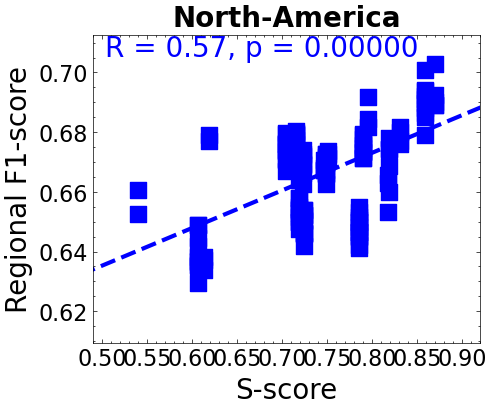

South-America
p-value 0.008134


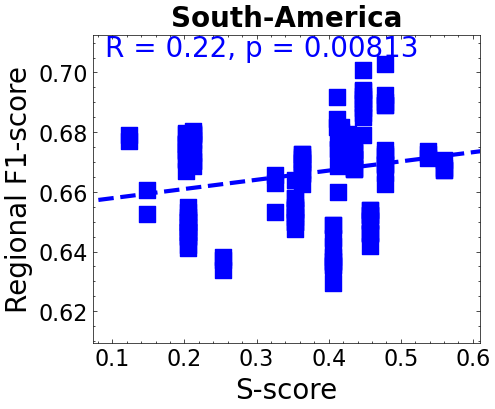

Europe
p-value 0.000000


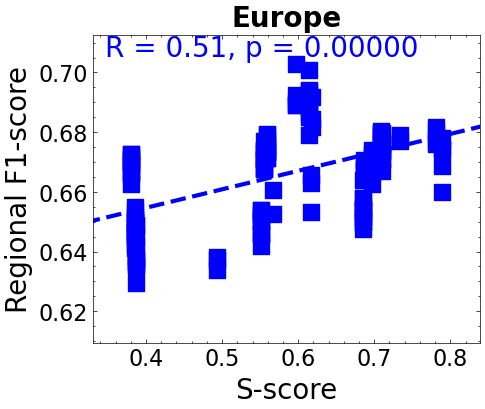

Africa
p-value 0.001275


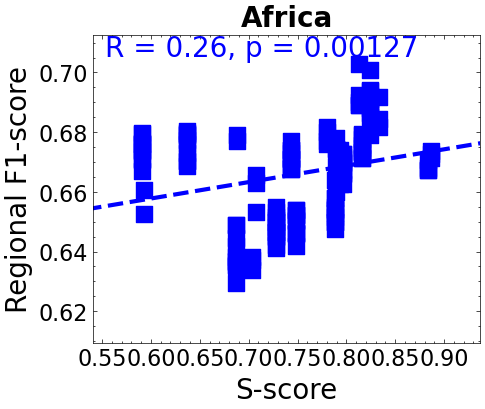

South-Asia
p-value 0.281964


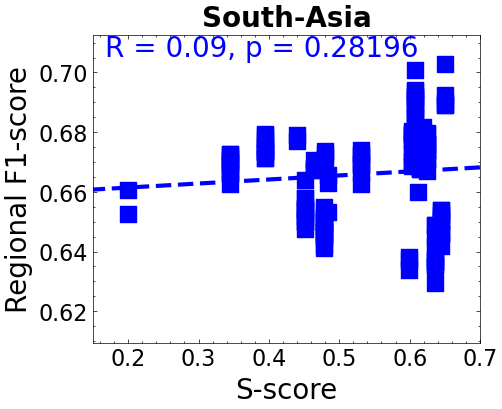

East-Asia
p-value 0.000000


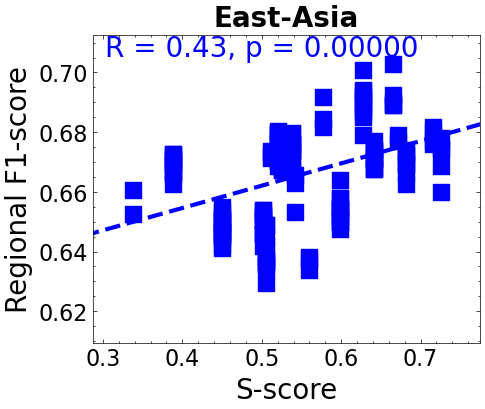

Oceania
p-value 0.000000


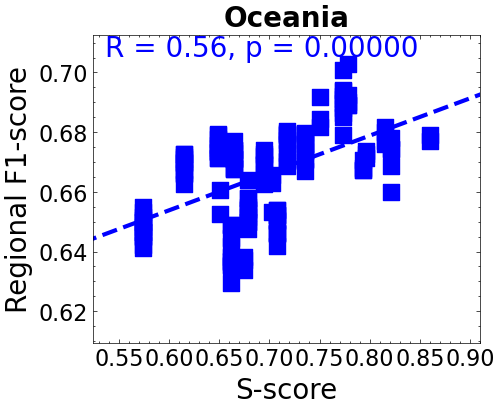

In [15]:
#Merge f1score and S-score in a single Dataframe on model keys
#df_sscore_f1_merged_res = pd.merge(df_sscoreNCEP,df_f1score_seasonaveraged, on=['model',"region"])
df_sscore_f1_merged_res = pd.merge(df_sscoreNCEP,df_f1score_seasonaveraged_global, on=['model'])
# idx_toremove = df_sscore_f1_merged_res[ df_sscore_f1_merged_res['model'] == "FGOALS-g3" ].index
# df_sscore_f1_merged_res.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_sscore_f1_merged_res[ df_sscore_f1_merged_res['model'] == "FGOALS-f3-L" ].index
# df_sscore_f1_merged_res.drop(index=idx_toremove,inplace=True)
#Print current dataframe
#print("Total number of ensembles kept : %d ." %len(df_sscore_f1_merged_res))
#print(df_sscore_f1_merged_res)

#df_sscore_f1_merged_res.to_csv("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/df_Fscore_and_regional_Sscore.csv")


#print(df_sscore_f1_merged_res[df_sscore_f1_merged_res["region"]=="Global"].to_string())
#print(len(df_sscore_f1_merged_res[df_sscore_f1_merged_res["region"]=="Global"]))

for region in mask_list:
    df_temp = df_sscore_f1_merged_res[df_sscore_f1_merged_res["region"]==region]
    print(region)
    #print(df_temp)
    #print(df_temp)
#print("Total number of ensembles kept : %d ." %len(df_modelmean_sscore))
    sscore_series= df_temp["S-score"].to_numpy()
    #print(sscore_series)
    f1_score_series = df_temp["F1-score"].to_numpy()
    plot_linregress(sscore_series,f1_score_series,region,"S-score","Regional F1-score")

### c.) Fit of the Delta-precip vs F1-score

#### Fitting F1-score averaged on all ensembles v. Delta-precip using a GPR, Polynomial regression, linear regression for SELECTED MODELS

F1-score v. DeltaPrecip for SSP585

In [10]:
pr_ssp585_2050_2099_regridtoNCEP= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp585_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp370_2050_2099_regridtoNCEP= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp370_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp245_2050_2099_regridtoNCEP="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp245_2050-2099_regridtoNCEP_extract_region_mean/"
pr_histo_1860_1910_regridtoNCEP="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1860-1910_regridtoNCEP_extract_region_mean/"
deltaPrecip_result_template="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/regional_deltaPrecip_%s_scenario_regridtoNCEP.csv"
mask_list = ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]

In [11]:
import pandas as pd
import numpy as np
#import xarray as xr
import os
import glob
import pickle
# import iris
# import iris.analysis.stats
import warnings
# import iris.coord_categorisation
warnings.simplefilter("ignore")
import copy

def compute_mean_diff(histo_cube,ssp_cube):
    spatial_diff= ssp_cube - histo_cube
    #compute area weighted mean
    try :
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    except ValueError:
        lat= spatial_diff.coord("latitude")
        lon= spatial_diff.coord("longitude")
        lon.guess_bounds()
        lat.guess_bounds()
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    return area_weighted_mean

def get_delta_precip(pr_histo_1860_1910_path, pr_scenario_path, scenario_name,make_dic,save_res,result_file_name,mask_list):
#Compute Precipitation difference on climatology between two periods for all model datasets.
#Saved in a dictionnary
    if make_dic:

        res_list=[]
        model_list=[]
        ensemble_list=[]
        region_list= []
        for region in mask_list:
            source_path_scenario = pr_scenario_path+"/"+region+"/"
            source_path_histo = pr_histo_1860_1910_path+"/"+region+"/"

            print(source_path_scenario+"/CMIP*.nc")
            for file_ in glob.glob(source_path_scenario+"/CMIP*.nc"):
                print(file_)
                try:
                    rcp85_file_name= os.path.basename(file_)
                    model_name= os.path.basename(rcp85_file_name).split("_")[1]
                    ensemble= os.path.basename(rcp85_file_name).split("_")[4]
                    if scenario_name =="rcp85":
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                    #elif scenario_name == "abrupt-4xCO2":
                    #    histo_file_name= glob.glob(piControl_path + "*"+model_name+"*.nc")[0]
                    #elif scenario_name == "abrupt-4xCO2_2" or scenario_name == "abrupt-4xCO2_130-150":
                    #    histo_file_name= glob.glob("/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/piControl_2_data/" + "*" + model_name + "*.nc")[0]
                    else:
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                        #if "NorESM2-LM" in rcp85_file_name:
                        #    histo_file_name = source_path_histo+histo_file_name.replace("r1i1p1f1","r2i1p1f1")

                    print("Computing Delta Precipitation between "+ scenario_name+" 2050-2100 and  1860-1910 for "+model_name+" "+ensemble)
                    #LOAD CUBE
                    rcp85_cube = iris.load_cube(file_,"precipitation_flux")
                    #print(source_path_histo+histo_file_name)
                    histo_cube = iris.load_cube(histo_file_name,"precipitation_flux")

                    #COMPUTE DIFF
                    diff_ = compute_mean_diff(histo_cube,rcp85_cube)
                    model_list.append(model_name)
                    ensemble_list.append(ensemble)
                    region_list.append(region)
                    res_list.append(diff_)
                    del histo_cube
                    del rcp85_cube
                except Exception as e:
                    print(e)
                    pass

        model,ensemble,region_list,res_list= (list(t) for t in zip(*sorted(zip(model_list,ensemble_list,region_list,res_list))))
        df_deltaPrecip= pd.DataFrame({"model":model,"ensemble":ensemble,"region":region_list,"deltaPrecip":res_list})
        if save_res:
            print("Now saving results in CSV format")
            df_deltaPrecip.to_csv(result_file_name)
    else:
        print("Loading file")
        df_deltaPrecip= pd.read_csv(result_file_name)
        df_deltaPrecip.drop("Unnamed: 0",axis=1,inplace=True)


    #Convert unit from kg/m2/s to mm/day
    df_deltaPrecip.loc[:,"deltaPrecip"]*=86400
    print(df_deltaPrecip.to_string())
    return(df_deltaPrecip)

In [12]:
make_dic=False
save_res= True
scenario_name = "ssp585"
df_deltaPrecip_ssp585 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp585_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp370"
df_deltaPrecip_ssp370 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp370_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp245"
df_deltaPrecip_ssp245 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp245_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)

make_dic= False

Loading file
               model  ensemble         region  deltaPrecip
0         ACCESS-CM2  r1i1p1f1         Africa     0.273723
1         ACCESS-CM2  r1i1p1f1      East-Asia     0.481154
2         ACCESS-CM2  r1i1p1f1         Europe     0.210783
3         ACCESS-CM2  r1i1p1f1         Global     0.216845
4         ACCESS-CM2  r1i1p1f1  North-America     0.327188
5         ACCESS-CM2  r1i1p1f1        Oceania    -0.007148
6         ACCESS-CM2  r1i1p1f1  South-America    -0.152244
7         ACCESS-CM2  r1i1p1f1     South-Asia     0.735578
8      ACCESS-ESM1-5  r1i1p1f1         Africa     0.205291
9      ACCESS-ESM1-5  r1i1p1f1      East-Asia     0.174964
10     ACCESS-ESM1-5  r1i1p1f1         Europe     0.064408
11     ACCESS-ESM1-5  r1i1p1f1         Global     0.039619
12     ACCESS-ESM1-5  r1i1p1f1  North-America     0.221718
13     ACCESS-ESM1-5  r1i1p1f1        Oceania    -0.501097
14     ACCESS-ESM1-5  r1i1p1f1  South-America    -0.572041
15     ACCESS-ESM1-5  r1i1p1f1     South-As

In [13]:
#Author: Peer Nowack
import numpy as np
import pylab
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
%matplotlib inline

# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n%s" % gp.kernel_
    s2 = "\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    return (s1 + s2)

def gaussian_process_fit(x, y,plot_title):

#     x -= x.mean()
#     x/=x.std()
    
#     y -= y.mean()
#     y/=y.std()
    
    # Specify observations
    n_obs = len(x)
    X_obs = x.reshape(n_obs, 1)
    x_min = x.min() - .1*(x.max()-x.min())
    x_max = x.max() + .1*(x.max()-x.min())
    f_obs = y
    
    #KERNEL used
    kernel = 10 * RBF(1, (1e-3, 1e3)) + WK(1)
#     kernel = 1 * M(1, (1e-2, 1e2), nu = 5/2) + WK(1)

    gp = GPR(kernel=kernel, alpha = 0.00000001, n_restarts_optimizer=20)
    gp.fit(X_obs, f_obs)
    print(summary(gp))

    # Make a prediction on test points
    X_test = np.array(np.linspace(x_min, x_max, 1000), ndmin = 2).T
    f_mean, f_var = gp.predict(X_test, return_std=True)

    # Create a Plot
    fig_noisy = plt.figure(figsize = (5,4))
    plt.rcParams.update({'font.size': 12})

    # Mark the observations
    plt.plot(X_obs, f_obs, 'ro', label='CMIP6 models')

    # Draw a mean function and 95% confidence interval
    plt.plot(X_test, f_mean, 'b-', label='mean function')
    upper_bound = f_mean + 1.96 * f_var
    lower_bound = f_mean - 1.96 * f_var
    plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.2,
                     label='95% confidence interval')

    # Draw samples from the posterior and plot
    # X_samples = np.array(np.linspace(x_min, x_max, 30), ndmin = 2).T
    # seed = np.random.randint(10) # random seed
    # plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

    # Aesthetics
    plt.xlabel('$\Delta$ Precipitation over land (mm/day)',size=24)
    plt.ylabel('Regional F1-score',size=24)
    plt.xlim(x_min, x_max)
    plt.title(plot_title)
    #plt.xlim(-0.05, 0.20)
    # plt.ylim(-3, 3)
    plt.legend(loc='lower left')
#     plt.title(summary(gp))
    plt.show()
def poly_fit_test(x, y,nickname, pvalue,title):
    plt.rcParams['figure.figsize'] = (5, 4)
    degree = 2

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = y

    weights = np.polyfit(x, y, degree)
    model = np.poly1d(weights)
    #print (model)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()
    #print(results.summary())
    p_val_poly= results.pvalues[1]
    
    x_min = x.min() - .3*(x.max()-x.min())
    x_max = x.max() + .3*(x.max()-x.min())
    y_min = y.min() - .05*(y.max()-y.min())
    y_max = y.max() + .05*(y.max()-y.min())    
    # Make a prediction on test points
    X_test = np.linspace(x_min, x_max, 1000)
    f_mean = model(X_test)
#     print (f_mean)
    # Create a Plot
    fig = plt.figure(figsize = (5,4))
    params = {'legend.fontsize': 'small',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)
    #plt.rcParams.update({'font.size': 16})
    # Mark the observations
    plt.plot(x, y, 'ko', label='CMIP6 models')
    plt.ylim(y_min,y_max)
    # Draw a mean function and 95% confidence interval
    plt.plot(X_test, f_mean, 'r-', label=r'y = a+b$\cdot$x+c$\cdot$x$^2$')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #print(slope, intercept, r_value, p_value)
    reg_line=intercept+slope*np.arange(x_min,x_max,0.02)
    plt.plot(np.arange(x_min,x_max,0.02),reg_line,color='b',linewidth=1,linestyle='-',label=r'y = a+b$\cdot$x')
    # Aesthetics
    plt.title(title)
    plt.figtext(0.15,0.825,'p = '+str(round(p_val_poly,5)),color='red')
    plt.figtext(0.15,0.775,'p = '+str(round(p_value,3)),color='blue')
    plt.xlabel('$\Delta$ Precipitation over land (mm/day)',size=16)
    plt.ylabel('F1-score against ERA5',size=16)
    plt.xlim(x_min, x_max)
    # plt.ylim(-3, 3)
    plt.legend(loc='lower left')
    plt.savefig('precip_vs_F1_polyfit_'+title[0:8]+'_ERA5.pdf',dpi=300)
    plt.show()

# Global results

Fitted Kernel(Optimized)
0.452**2 * RBF(length_scale=0.563) + WhiteKernel(noise_level=0.000139)
log marginal likelihood: 57.37939


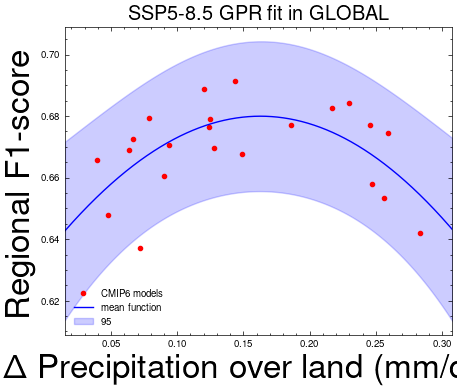

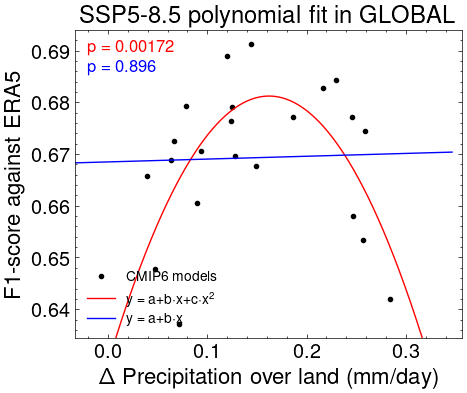

In [14]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp585[df_deltaPrecip_ssp585["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-g3" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CNRM-CM6-1"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp585 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp585 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp585,f1_series_ssp585,"SSP5-8.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp585,f1_series_ssp585,"",0.01,"SSP5-8.5 polynomial fit in GLOBAL")

In [15]:
df_f1score_seasonaveraged_global

F1-score
model         ensemble          
ACCESS-CM2    r1i1p1f1  0.682719
              r2i1p1f1  0.686207
              r3i1p1f1  0.682118
ACCESS-ESM1-5 r1i1p1f1  0.665744
              r2i1p1f1  0.653245
...                          ...
UKESM1-0-LL   r5i1p1f3  0.678916
              r6i1p1f3  0.694231
              r7i1p1f3  0.686554
              r8i1p1f2  0.689638
              r9i1p1f2  0.688085

[169 rows x 1 columns]

Fitted Kernel(Optimized)
0.668**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.000194)
log marginal likelihood: 54.56066


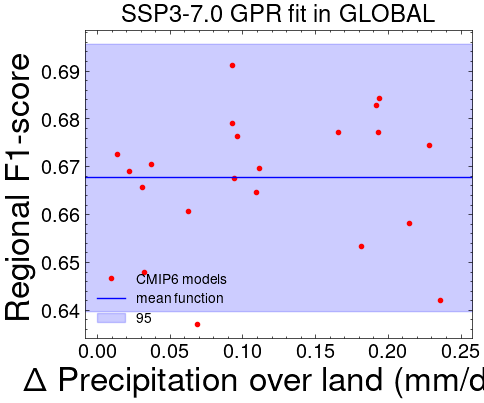

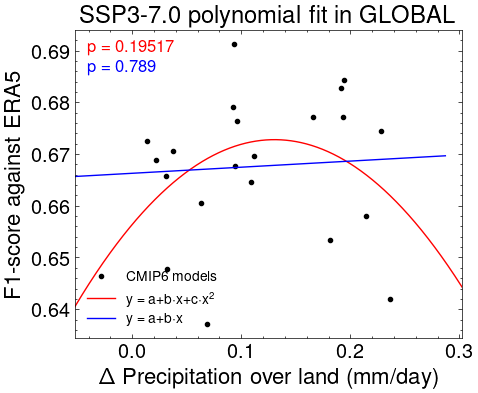

In [16]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp370[df_deltaPrecip_ssp370["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-g3" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CNRM-CM6-1"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "GFDL-ESM4"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp370 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp370 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp370,f1_series_ssp370,"SSP3-7.0 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp370,f1_series_ssp370,"",0.01,"SSP3-7.0  polynomial fit in GLOBAL")

Fitted Kernel(Optimized)
0.669**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.000191)
log marginal likelihood: 57.55831


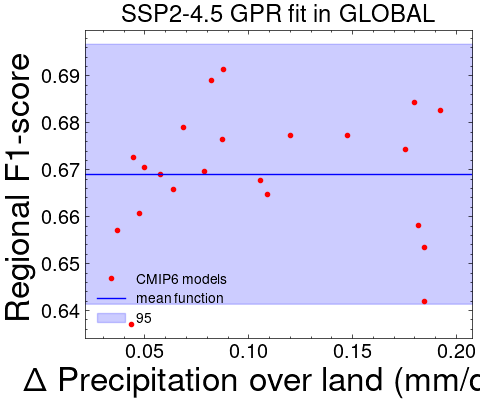

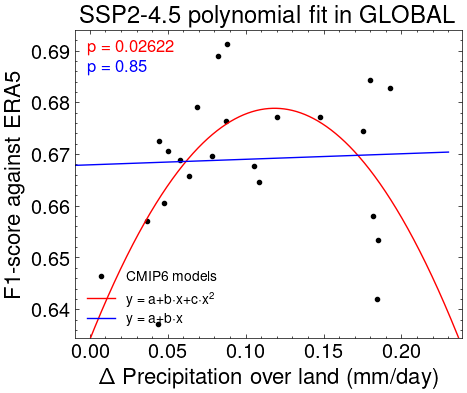

In [17]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp245[df_deltaPrecip_ssp245["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-g3" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CNRM-CM6-1"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "GFDL-ESM4"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp245 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp245 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp245,f1_series_ssp245,"SSP2-4.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp245,f1_series_ssp245,"",0.01,"SSP2-4.5  polynomial fit in GLOBAL")

In [18]:
df_deltaPrecip_f1score

,model,ensemble,region,deltaPrecip,F1-score
0,ACCESS-CM2,r1i1p1f1,Global,0.192391,0.682719
1,ACCESS-ESM1-5,r1i1p1f1,Global,0.063526,0.665744
2,BCC-CSM2-MR,r1i1p1f1,Global,0.043686,0.637083
3,CESM2,r1i1p1f1,Global,0.049924,0.670571
4,CESM2-WACCM,r1i1p1f1,Global,0.044683,0.672597
5,CNRM-CM6-1,r1i1p1f2,Global,0.068480,0.679049
6,CNRM-CM6-1-HR,r1i1p1f2,Global,0.108830,0.664694
7,CNRM-ESM2-1,r1i1p1f2,Global,0.087176,0.676440
8,CanESM5,r1i1p1f1,Global,0.184720,0.653341
9,EC-Earth3,r1i1p1f1,Global,0.147460,0.677209


### Calculate interdependence

In [19]:
make_dic=True
global_f1_path = "/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_f1_independence_era5_1979-2014_weights_alpha_%s_%s_selected_comps.bin"

In [20]:
####This cell creates df_f1score pandasframe which stores F1-score for all season,model,ensemble triplets
alpha = 0.0001
timebin = "timebin1x2"
global_f1_path=global_f1_path%(str(alpha),timebin)
if make_dic:
    df_f1score= {}
    p_mat_dic=global_res["p_val"][alpha]
    val_mat_dic= global_res["val_mat"][alpha]
    score_list =[]
    for season in val_mat_dic:
        if season !="global":#drop global
            for dataset in val_mat_dic[season]:
                for ensemble in val_mat_dic[season][dataset]:
                    for dataset2 in val_mat_dic[season]:
                        for ensemble2 in val_mat_dic[season][dataset2]:
                            if not (dataset2== dataset and ensemble2 == ensemble):
                                ref_p_matrix= p_mat_dic[season][dataset2][ensemble2]
                                p_matrix= p_mat_dic[season][dataset][ensemble]
                                ref_val_matrix= val_mat_dic[season][dataset2][ensemble2]
                                val_matrix= val_mat_dic[season][dataset][ensemble]
                                precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:50,:50,:], p_matrix[:50,:50,:], ref_val_matrix[:50,:50,:], val_matrix[:50,:50,:], alpha, 
                                tau_min=1, tau_diff=2, same_sign=True)
                                score_list.append([season,dataset,ensemble,dataset2,ensemble2,score])
                                #print([season,dataset,ensemble,dataset2,ensemble2,score])
    season,dataset,ensemble,dataset2,ensemble2,score= [list(a) for a in zip(*score_list)]
    df_f1score_ = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"ref_model":dataset2,"ref_ensemble":ensemble2,"F1-score":score})
    #get average F1-score over seasons
    #df_f1score_seasonaveraged = df_f1score_.groupby(["model","ensemble"])["F1-score"].mean()
    #df_f1score[alpha]= df_f1score_seasonaveraged
    pickle.dump(df_f1score_,open(global_f1_path,"wb"))
    df_f1score = df_f1score_
else:
    df_f1score = pickle.load(open(global_f1_path,"rb"))

In [21]:
to_keep = ["FGOALS-g3_r1i1p1f1",
"FGOALS-g3_r3i1p1f1",
"KACE-1-0-G_r3i1p1f1",
"MIROC-ES2L_r10i1p1f2",
"MIROC-ES2L_r1i1p1f2",
"MIROC-ES2L_r2i1p1f2",
"MIROC-ES2L_r3i1p1f2",
"MIROC-ES2L_r4i1p1f2",
"MIROC-ES2L_r5i1p1f2",
"MIROC-ES2L_r6i1p1f2",
"MIROC-ES2L_r7i1p1f2",
"MIROC-ES2L_r8i1p1f2",
"MIROC-ES2L_r9i1p1f2",
"MIROC6_r10i1p1f1",
"MIROC6_r1i1p1f1",
"MIROC6_r2i1p1f1",
"MIROC6_r3i1p1f1",
"MIROC6_r4i1p1f1",
"MIROC6_r5i1p1f1",
"MIROC6_r6i1p1f1",
"MIROC6_r7i1p1f1",
"MIROC6_r8i1p1f1",
"MIROC6_r9i1p1f1",
"MPI-ESM1-2-HR_r1i1p1f1",
"MPI-ESM1-2-HR_r2i1p1f1",
"MPI-ESM1-2-LR_r10i1p1f1",
"MPI-ESM1-2-LR_r1i1p1f1",
"MPI-ESM1-2-LR_r2i1p1f1",
"MPI-ESM1-2-LR_r3i1p1f1",
"MPI-ESM1-2-LR_r4i1p1f1",
"MPI-ESM1-2-LR_r5i1p1f1",
"MPI-ESM1-2-LR_r6i1p1f1",
"MPI-ESM1-2-LR_r7i1p1f1",
"MPI-ESM1-2-LR_r8i1p1f1",
"MPI-ESM1-2-LR_r9i1p1f1",
"MRI-ESM2-0_r1i1p1f1",
"MRI-ESM2-0_r1i2p1f1",
"MRI-ESM2-0_r2i1p1f1",
"MRI-ESM2-0_r3i1p1f1",
"MRI-ESM2-0_r4i1p1f1",
"MRI-ESM2-0_r5i1p1f1",
"NorESM2-LM_r1i1p1f1",
"UKESM1-0-LL_r1i1p1f2",
"UKESM1-0-LL_r2i1p1f2",
"UKESM1-0-LL_r3i1p1f2",
"UKESM1-0-LL_r4i1p1f2",
"KACE-1-0-G_r2i1p1f1",
"KACE-1-0-G_r1i1p1f1",
"ACCESS-CM2_r1i1p1f1",
"ACCESS-CM2_r2i1p1f1",
"ACCESS-CM2_r3i1p1f1",
"ACCESS-ESM1-5_r1i1p1f1",
"ACCESS-ESM1-5_r2i1p1f1",
"ACCESS-ESM1-5_r3i1p1f1",
"BCC-CSM2-MR_r1i1p1f1",
"CESM2_r1i1p1f1",
"CESM2-WACCM_r1i1p1f1",
"CESM2-WACCM_r2i1p1f1",
"CESM2-WACCM_r3i1p1f1",
"CNRM-CM6-1_r1i1p1f2",
"CNRM-CM6-1_r2i1p1f2",
"CNRM-CM6-1_r3i1p1f2",
"CNRM-CM6-1_r4i1p1f2",
"CNRM-CM6-1_r5i1p1f2",
"CNRM-CM6-1_r6i1p1f2",
"CNRM-ESM2-1_r1i1p1f2",
"CNRM-ESM2-1_r2i1p1f2",
"CNRM-ESM2-1_r3i1p1f2",
"CNRM-ESM2-1_r4i1p1f2",
"CNRM-ESM2-1_r5i1p1f2",
"CanESM5_r10i1p1f1",
"CanESM5_r1i1p1f1",
"CanESM5_r1i1p2f1",
"CanESM5_r2i1p1f1",
"CanESM5_r2i1p2f1",
"CanESM5_r3i1p1f1",
"CanESM5_r3i1p2f1",
"CanESM5_r4i1p1f1",
"CanESM5_r4i1p2f1",
"CanESM5_r5i1p1f1",
"CanESM5_r6i1p1f1",
"CanESM5_r7i1p1f1",
"CanESM5_r8i1p1f1",
"CanESM5_r9i1p1f1",
"EC-Earth3_r11i1p1f1",
"EC-Earth3_r1i1p1f1",
"EC-Earth3_r4i1p1f1",
"EC-Earth3-Veg_r1i1p1f1",
"EC-Earth3-Veg_r2i1p1f1",
"EC-Earth3-Veg_r3i1p1f1",
"EC-Earth3-Veg_r4i1p1f1",
"HadGEM3-GC31-LL_r1i1p1f3",
"HadGEM3-GC31-LL_r2i1p1f3",
"HadGEM3-GC31-LL_r3i1p1f3",
"HadGEM3-GC31-LL_r4i1p1f3",
"HadGEM3-GC31-MM_r1i1p1f3",
"HadGEM3-GC31-MM_r2i1p1f3",
"HadGEM3-GC31-MM_r3i1p1f3",
"HadGEM3-GC31-MM_r4i1p1f3",
"INM-CM5-0_r1i1p1f1",
"IPSL-CM6A-LR_r1i1p1f1",
"IPSL-CM6A-LR_r2i1p1f1",
"IPSL-CM6A-LR_r3i1p1f1",
"IPSL-CM6A-LR_r4i1p1f1",
"IPSL-CM6A-LR_r6i1p1f1"]

In [22]:
import copy
import seaborn as sn
import matplotlib
import pylab
df_heatmap = df_f1score
df_heatmap["model_ensemble_reference"] = df_heatmap[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap["model_ensemble"] = df_heatmap[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap = df_heatmap[df_heatmap["model_ensemble_reference"].isin(to_keep)]
df_heatmap = df_heatmap[df_heatmap["model_ensemble"].isin(to_keep)]
df_heatmap = df_heatmap.groupby(["model","ref_model"],as_index=False)["F1-score"].mean()
df_heatmap_n= df_heatmap.pivot(index="model",columns="ref_model")["F1-score"]
df_heatmap_r= df_heatmap.pivot(columns="model",index="ref_model")["F1-score"]
np.fill_diagonal(df_heatmap_n.values, np.nan)
np.fill_diagonal(df_heatmap_r.values, np.nan)
df_heatmap_sym = (df_heatmap_n+df_heatmap_r)/2.

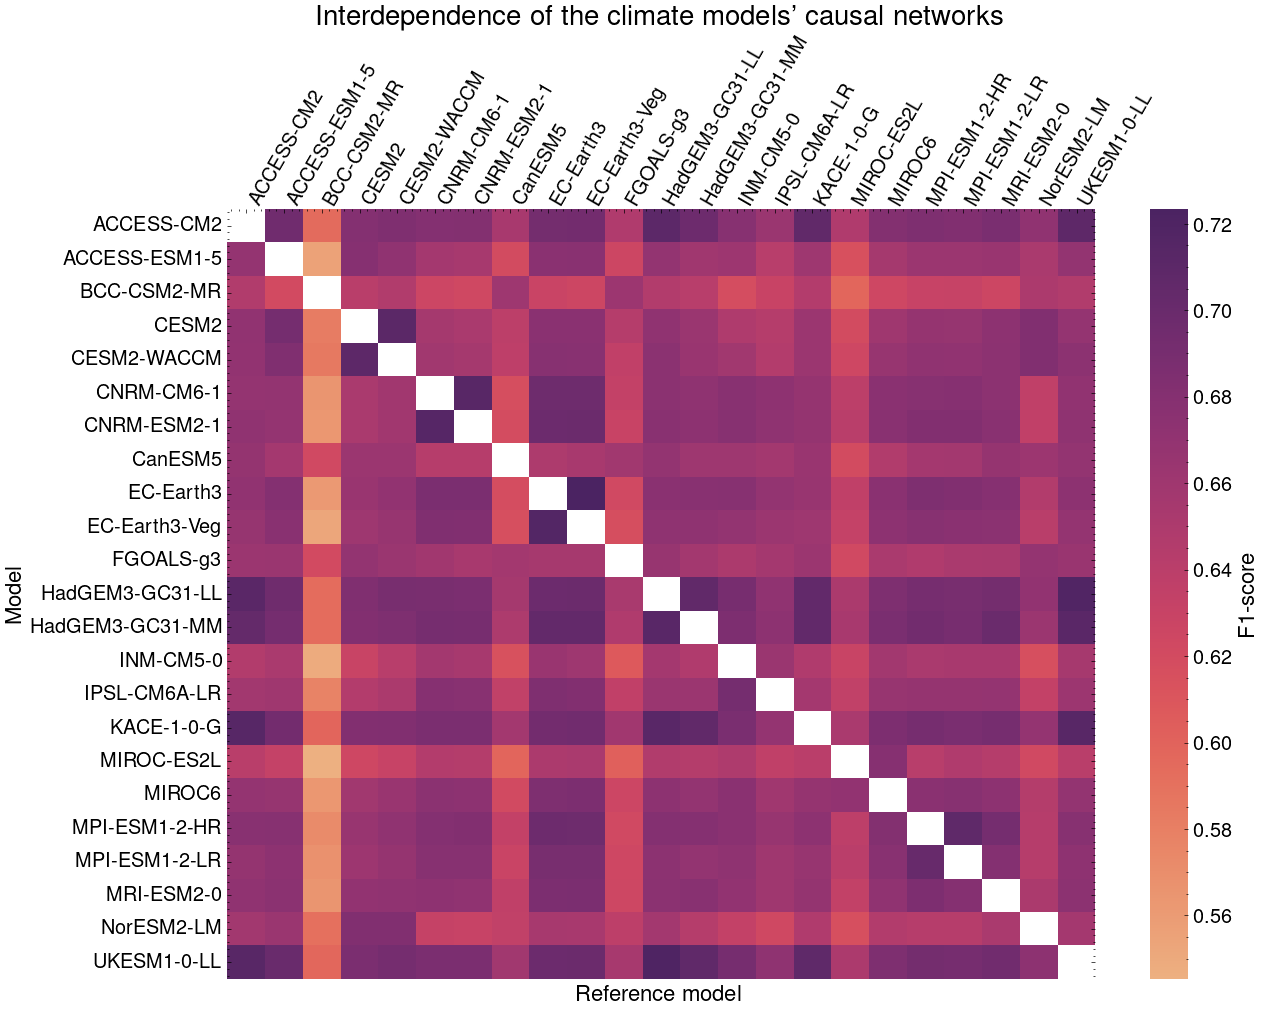

In [23]:
cmap = sn.color_palette("flare", as_cmap=True) #sn.color_palette("magma_r", as_cmap=True)# #sn.color_palette("magma_r", as_cmap=True) # ## # #matplotlib.cm.get_cmap('hot_r')
fig = plt.figure(figsize=(14,10))
params = {'legend.fontsize': 'small',
        #'figure.figsize': (15, 5),
        'axes.labelsize': 'large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)
g = sn.heatmap(df_heatmap_n, cmap=cmap,annot=False)
g.xaxis.set_ticks_position("top")
g.collections[0].colorbar.set_label("F1-score",fontsize=16)
g.set_title('Interdependence of the climate models\' causal networks',fontsize=20,weight="bold")
g.set_xlabel('Reference model',fontsize=16,weight="bold")
g.set_ylabel('Model',fontsize=16,weight="bold")
g.set_xticklabels(g.get_xticklabels(), rotation=60,verticalalignment= 'baseline',horizontalalignment= "left")
plt.savefig('interdependence_heatmap_50comps_ERA5.pdf',dpi=300)
plt.show()


In [24]:
import copy
df_f1score_selected_models = df_f1score
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
#list_discarded = ["CESM2-WACCM-FV2","CESM2-FV2","GFDL-ESM4","GFDL-CM4","ncar"]
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble_reference"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models.drop(columns=["ref_model","ref_ensemble","model","ensemble"])
df_f1score_selected_models= df_f1score_selected_models.groupby(["model_ensemble","model_ensemble_reference"],as_index=False)["F1-score"].mean()
df_ssp370 = copy.copy(df_f1score_selected_models)
df_ssp245 = copy.copy(df_f1score_selected_models)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models["model_ensemble"]+"_historical-ssp585"
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models["model_ensemble_reference"]+"_historical-ssp585"
df_ssp370["model_ensemble"] = df_ssp370["model_ensemble"]+"_historical-ssp370"
df_ssp370["model_ensemble_reference"] = df_ssp370["model_ensemble_reference"]+"_historical-ssp370"
df_ssp245["model_ensemble"] = df_ssp245["model_ensemble"]+"_historical-ssp245"
df_ssp245["model_ensemble_reference"] = df_ssp245["model_ensemble_reference"]+"_historical-ssp245"


In [25]:
df_f1score_selected_models_reversed = df_f1score
df_f1score_selected_models_reversed["model_ensemble"] = df_f1score_selected_models_reversed[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_selected_models_reversed["model_ensemble_reference"] = df_f1score_selected_models_reversed[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
#list_discarded = ["CESM2-WACCM-FV2","CESM2-FV2","GFDL-ESM4","GFDL-CM4","ncar"]
df_f1score_selected_models_reversed = df_f1score_selected_models_reversed[df_f1score_selected_models_reversed["model_ensemble_reference"].isin(to_keep)]
df_f1score_selected_models_reversed = df_f1score_selected_models_reversed[df_f1score_selected_models_reversed["model_ensemble"].isin(to_keep)]
df_f1score_selected_models_reversed = df_f1score_selected_models_reversed.drop(columns=["ref_model","ref_ensemble","model","ensemble"])
df_f1score_selected_models_reversed= df_f1score_selected_models_reversed.groupby(["model_ensemble","model_ensemble_reference"],as_index=False)["F1-score"].mean()

In [26]:
import xarray as xr
# old_ind_weights = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_xr_ind_1979-2014_weights_alpha0.0001_timebin1x2_selected_comps.nc")
# old_perf_weights = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_xr_perf_era5_1979-2014_weights_alpha0.0001_timebin1x2_selected_comps.nc")

In [27]:
new_xr_ind = df_f1score_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp370 = df_ssp370.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp245 = df_ssp245.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()

In [28]:
new_xr_ind=new_xr_ind.dcme
new_xr_ind_ssp370=new_xr_ind_ssp370.dcme
new_xr_ind_ssp245=new_xr_ind_ssp245.dcme

In [29]:
new_xr_ind= 1 - new_xr_ind.fillna(1.0)
new_xr_ind_ssp370= 1 - new_xr_ind_ssp370.fillna(1.0)
new_xr_ind_ssp245= 1 - new_xr_ind_ssp245.fillna(1.0)

In [30]:
new_xr_ind.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp370.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp245.attrs={"variable_group":"cme","units":""}


In [31]:
#new_xr_ind.rename({'model_ensemble_reference': 'perfect_model_ensemble'})

In [32]:
def barplot(metric: 'xr.DataArray', filename: str):
    """Visualize metric as barplot."""
    name = metric.name
    variable_group = metric.variable_group
    units = metric.units

    metric_df = metric.to_dataframe().reset_index()

    ylabel = f' {variable_group}'

    figure, axes = plt.subplots(figsize=(10, 7))
    chart = sn.barplot(x='model',
                        y=name,
                        data=metric_df,
                        ax=axes,
                        color="blue")
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
    if variable_group == 'weight':
        chart.set_title('Performance weights')
    else:
        chart.set_title(f'{variable_group} against ERA5 causal networks')
    chart.set_ylabel(ylabel)
    chart.set_xlabel('')
    ymin,ymax = chart.get_ylim()
    chart.set_ylim([0.5,ymax])
    figure.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(figure)

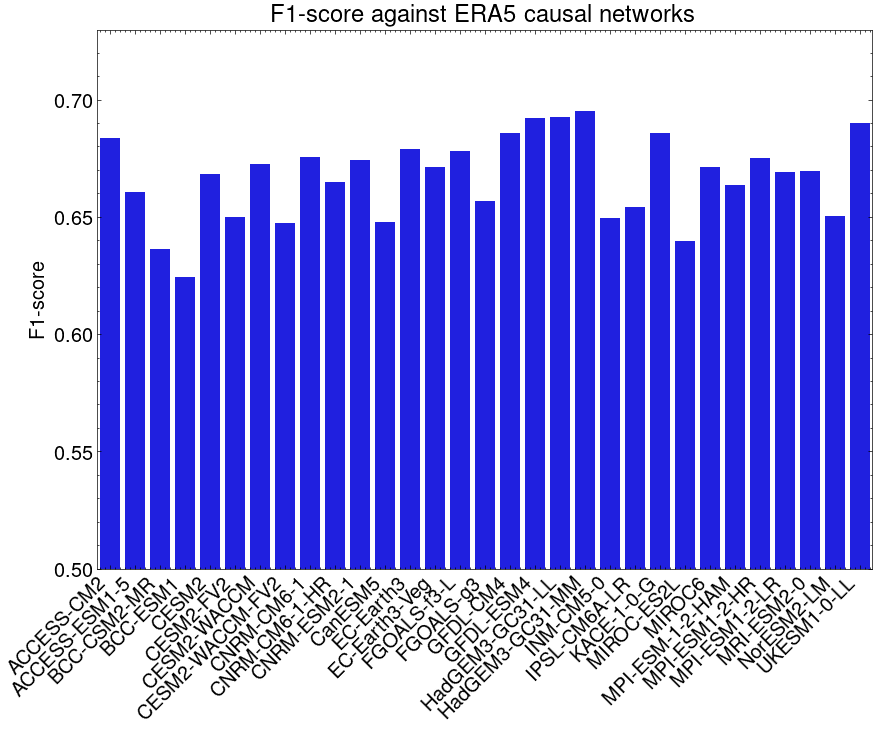

In [33]:
df_plot_perf = df_f1score_global.groupby(["model"],as_index=False)["F1-score"].mean()
xr_plot_perf = xr.DataArray(data=df_plot_perf["F1-score"].values,dims=["model"],
                            coords=dict(model=("model",df_plot_perf.model.values)),
                            attrs= {"variable_group":"F1-score","units":""},name="F1-score")
barplot(xr_plot_perf , "performance_50comps_ERA5.pdf")


In [34]:
#list_discarded = ["FGOALS-f3-L","FGOALS-g3","CESM2-WACCM-FV2","CESM2-FV2","GFDL-ESM4","GFDL-CM4","ncar"]
df_f1score_perf_selected_models = df_f1score_global.groupby(["model","ensemble"],as_index=False)["F1-score"].mean()
df_f1score_perf_selected_models["model_ensemble"] = df_f1score_perf_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_perf_selected_models = df_f1score_perf_selected_models[df_f1score_perf_selected_models.isin(to_keep).any(axis=1)]
df_f1score_perf_selected_models = df_f1score_perf_selected_models.drop(columns=["model","ensemble"])
# list_discarded = ['CNRM-CM6-1-HR_r1i1p1f2',
#  'HadGEM3-GC31-LL_r4i1p1f1',
#  'UKESM1-0-LL_r7i1p1f3',
#  'UKESM1-0-LL_r8i1p1f2',
#  'UKESM1-0-LL_r9i1p1f2']
# df_f1score_perf_selected_models = df_f1score_perf_selected_models[~df_f1score_perf_selected_models.isin(list_discarded).any(axis=1)]
# df_f1score_perf_selected_models["model_ensemble"] = df_f1score_perf_selected_models["model_ensemble"]+"_historical-ssp585"
df_f1score_perf_selected_models = df_f1score_perf_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble'])#.to_xarray()

In [35]:
new_xr_perf =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp370 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp370.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp245 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp245.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")

In [36]:
new_xr_perf = 1.-new_xr_perf
new_xr_perf_ssp370 = 1.-new_xr_perf_ssp370
new_xr_perf_ssp245 = 1.-new_xr_perf_ssp245

In [37]:
new_xr_perf.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp370.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp245.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}

In [38]:
metric_df = new_xr_perf.to_dataframe().reset_index()
metric_df[['model','ensemble','run']] = metric_df['model_ensemble'].str.split('_',expand=True)
metric_df.groupby(["model"])["dcme"].mean().to_frame()

,dcme
model,
ACCESS-CM2,0.316319
ACCESS-ESM1-5,0.339338
BCC-CSM2-MR,0.362917
CESM2,0.328674
CESM2-WACCM,0.327736
CNRM-CM6-1,0.326324
CNRM-ESM2-1,0.324616
CanESM5,0.352074
EC-Earth3,0.329157


In [39]:
new_xr_perf.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_ind.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_perf_ssp370.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_ind_ssp370.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_perf_ssp245.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_pcmci_parcorr_timebin1_ssp245.nc")
new_xr_ind_ssp245.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_pcmci_parcorr_timebin1_ssp245.nc")

In [ ]:
import xarray as xr
import numpy as np

In [ ]:
from typing import Union
def calculate_weights_data(
        performance: Union['np.array', None],
        independence: Union['np.array', None],
        performance_sigma: Union[float, None],
        independence_sigma: Union[float, None]) -> 'np.array':
    """Calculate normalized weights for each model N.

    Parameters
    ----------
    performance : array_like, shape (N,) or None
        Array specifying the model performance. None is mutually exclusive
        with independence being None. Single values in performance can be
        nan, then they will be excluded from the independence calculation as
        well (used for the perfect model test).
    independence : array_like, shape (N, N) or None
        Array specifying the model independence. None is mutually exclusive
        with performance being None.
    performance_sigma : float or None
        Sigma value defining the form of the weighting function
        for the performance. Can be one only if performance is also None.
    independence_sigma : float or None
        Sigma value defining the form of the weighting function
            for the independence. Can be one only if independence is also None.

    Returns
    -------
    weights : ndarray, shape (N,)
    """
    numerator = 1
    not_nan = None
    denominator = 1

    if performance is not None:
        numerator = np.exp(-((performance / performance_sigma)**2))
        # nans in the performance vector indicate models to be excluded
        not_nan = np.isfinite(performance)
    if independence is not None:
        if not_nan is None:
            not_nan = np.isfinite(independence[0])
        # don't consider nan models for independence of other models!
        exp = np.exp(-((independence[:, not_nan] / independence_sigma)**2))
        # Note diagonal = exp(0) = 1, thus this is equal to 1 + sum(i!=j)
        denominator = exp.sum(axis=1)

    weights = numerator / denominator
    weights /= weights.sum(where=not_nan)
    return weights

In [ ]:
performance_core_dims = [] if new_xr_perf is None else ['model_ensemble']
independence_core_dims = [] if new_xr_ind is None else ['model_ensemble', 'model_ensemble_reference']
weights = xr.apply_ufunc(
calculate_weights_data,
new_xr_perf,
new_xr_ind,
0.5,
0.5,
input_core_dims=[
    performance_core_dims, independence_core_dims, [], []
],
output_core_dims=[['model_ensemble']],
vectorize=True,
)